# Exploration of image interpretable representations

In [1]:
import os

_base_path = ('https://raw.githubusercontent.com/fat-forensics/resources/'
              'master/surrogates_overview/scripts/{}')
_scripts = ['__init__.py', 'image_classifier.py', 'imagenet_label_map.py']
! mkdir -p scripts
for i in _scripts:
    i_ = _base_path.format(i)
    if not os.path.exists(f'scripts/{i}'):
        ! wget $i_ -O scripts/$i

! mkdir -p _figures

In [2]:
# NBVAL_IGNORE_OUTPUT
import fatf

import fatf.utils.data.segmentation as fatf_segmentation
import fatf.utils.data.occlusion as fatf_occlusion

import scripts.image_classifier as imgclf

from helpers import plot_bar_exp

22-May-29 21:14:20 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [3]:
from PIL import Image

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rc('text', usetex=True)
plt.style.use('seaborn')  # 'classic'

In [4]:
def imshow(img):
    plt.grid(None)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [5]:
husky = Image.open('img/husky.jpeg')
husky_array = np.asarray(husky)
husky_mask = Image.open('img/husky_mask.jpeg')
husky_mask_array = np.asarray(husky_mask)

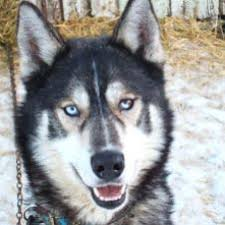

In [6]:
husky

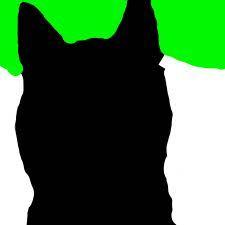

In [7]:
husky_mask

In [8]:
clf = imgclf.ImageClassifier()

clf.proba2tuple(
    clf.predict_proba([husky_array]),
    labels_no=5
)

/python/python3.7/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


[[('Eskimo dog', 0.8446185, 248),
  ('Siberian husky', 0.15534666, 250),
  ('malamute', 2.1785445e-05, 249),
  ('dogsled', 9.834689e-06, 537),
  ('timber wolf', 8.2559114e-07, 269)]]

## Segmentation

In [9]:
fatf.setup_random_seed(42)

segmenter = fatf_segmentation.QuickShift(
    husky_array,
    segmentation_mask=husky_mask_array,
    ratio=0.3,
    kernel_size=9,
    max_dist=30)

22-May-29 21:14:23 fatf         INFO     Seeding RNGs using the input parameter.
22-May-29 21:14:23 fatf         INFO     Seeding RNGs with 42.


In [10]:
print(f'Number of segments: {segmenter.segments_number}')

Number of segments: 11


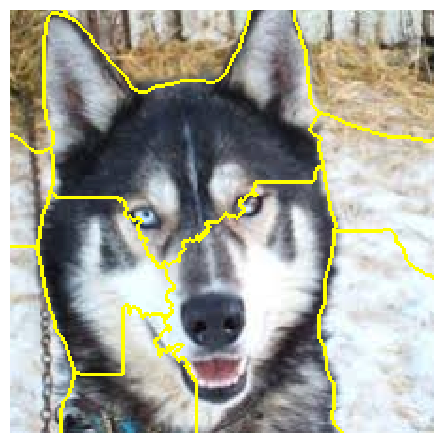

In [11]:
husky_segmented = segmenter.mark_boundaries(colour=(255, 255, 0))

imshow(husky_segmented)

In [12]:
plt.imsave('_figures/husky_segments.jpeg', husky_segmented)

## Occlusion

In [13]:
occluder = fatf_occlusion.Occlusion(husky_array, segmenter.segments)

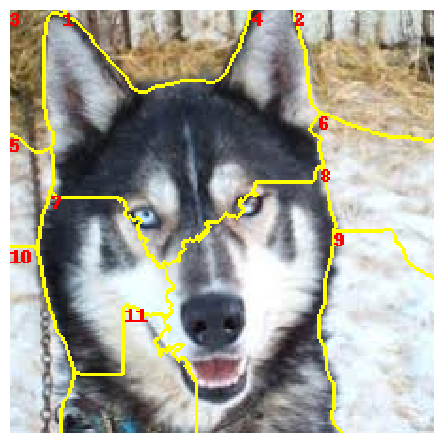

In [14]:
imshow(
    segmenter.number_segments(image=husky_segmented, colour=(255, 0, 0))
)

In [15]:
occlusion_mask = np.zeros(segmenter.segments_number, dtype=np.int8)
occlusion_mask[3] = 1

### Mean

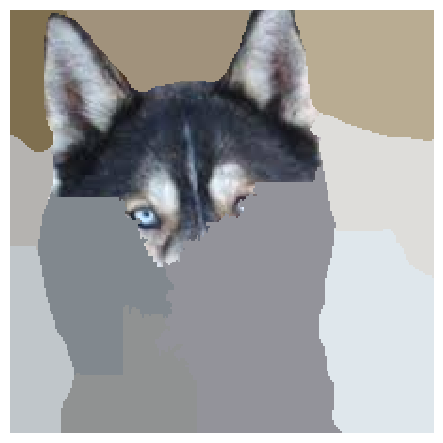

In [16]:
husky_occlusion_mean = occluder.occlude_segments_vectorised(
    occlusion_mask, colour='mean')

imshow(husky_occlusion_mean)

In [17]:
plt.imsave('_figures/husky_occlusion_mean.jpeg', husky_occlusion_mean)

In [18]:
clf.proba2tuple(
    clf.predict_proba([husky_occlusion_mean]),
    labels_no=5
)

[[('Eskimo dog', 0.77855957, 248),
  ('Siberian husky', 0.20185123, 250),
  ('malamute', 0.017923603, 249),
  ('kelpie', 0.0015429033, 227),
  ('dogsled', 5.4805725e-05, 537)]]

### Black

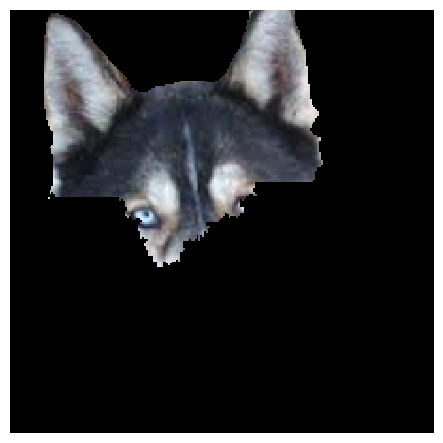

In [19]:
husky_occlusion_black = occluder.occlude_segments_vectorised(
    occlusion_mask, colour='black')

imshow(husky_occlusion_black)

In [20]:
plt.imsave('_figures/husky_occlusion_black.jpeg', husky_occlusion_black)

In [21]:
clf.proba2tuple(
    clf.predict_proba([husky_occlusion_black]),
    labels_no=5
)

[[('Siberian husky', 0.71412003, 250),
  ('Eskimo dog', 0.14804356, 248),
  ('Chihuahua', 0.090272576, 151),
  ('Egyptian cat', 0.023851015, 285),
  ('Pembroke', 0.006935258, 263)]]

### Random

22-Sep-05 14:42:35 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-05 14:42:35 fatf         INFO     Seeding RNGs with 42.


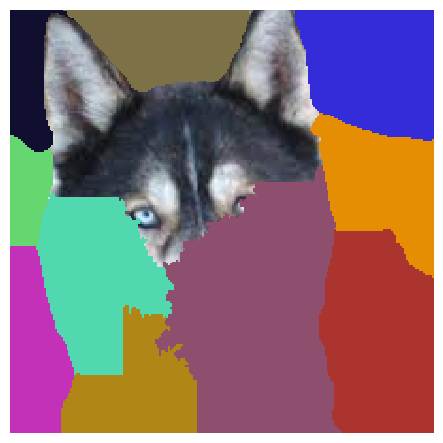

In [22]:
fatf.setup_random_seed(42)

husky_occlusion_random = occluder.occlude_segments_vectorised(
    occlusion_mask, colour='random-patch')

imshow(husky_occlusion_random)

In [23]:
plt.imsave('_figures/husky_occlusion_random.jpeg', husky_occlusion_random)

In [24]:
clf.proba2tuple(
    clf.predict_proba([husky_occlusion_random]),
    labels_no=5
)

[[('Eskimo dog', 0.5559604, 248),
  ('Siberian husky', 0.44283286, 250),
  ('malamute', 0.0010788848, 249),
  ('dogsled', 4.1053256e-05, 537),
  ('muzzle', 2.817556e-05, 676)]]

### Mosaic

In [25]:
segments_no = [30, 75, 100]

segments_step = []
for i in segments_no:
    fatf.setup_random_seed(42)
    s = fatf_segmentation.Slic(husky_array, n_segments=i)
    o = fatf_occlusion.Occlusion(husky_array, s.segments, colour='mean')
    segments_step.append((s, o))

22-May-29 21:14:32 fatf         INFO     Seeding RNGs using the input parameter.
22-May-29 21:14:32 fatf         INFO     Seeding RNGs with 42.
22-May-29 21:14:32 fatf         INFO     Seeding RNGs using the input parameter.
22-May-29 21:14:32 fatf         INFO     Seeding RNGs with 42.
22-May-29 21:14:32 fatf         INFO     Seeding RNGs using the input parameter.
22-May-29 21:14:32 fatf         INFO     Seeding RNGs with 42.


In [26]:
def find_dog_prediction(tuple_list):
    classes = ('Siberian husky', 'Eskimo dog', 'malamute')
    return [i for i in tuple_list if i[0] in classes]

Segments #: 17 (set to 30)
Top 5 predictions:  [('diaper', 0.11473322, 529), ('bearskin', 0.10694464, 439), ('caldron', 0.060546048, 469), ('coffee mug', 0.055410426, 504), ('cauliflower', 0.047042478, 938)]
Dog predictions:  [('malamute', 0.000100968784, 249), ('Siberian husky', 6.0771676e-05, 250), ('Eskimo dog', 4.2535015e-05, 248)]


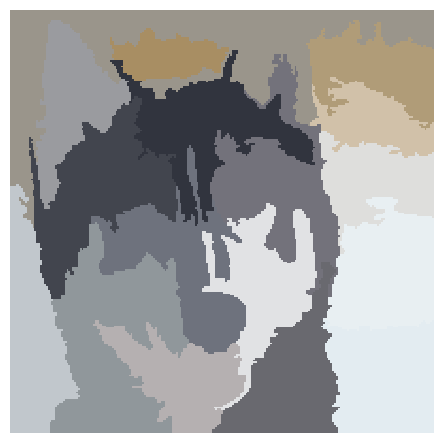

Segments #: 51 (set to 75)
Top 5 predictions:  [('triceratops', 0.24944405, 51), ('brassiere', 0.15365472, 459), ('mask', 0.10356463, 643), ('conch', 0.061524168, 112), ('ashcan', 0.058460582, 412)]
Dog predictions:  [('Siberian husky', 0.00050350965, 250), ('malamute', 0.00036568398, 249), ('Eskimo dog', 0.00032685255, 248)]


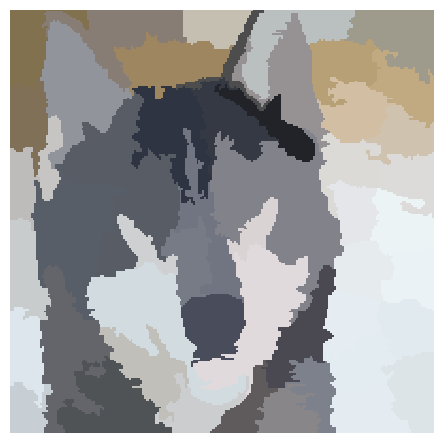

Segments #: 71 (set to 100)
Top 5 predictions:  [('brassiere', 0.55661774, 459), ('cauliflower', 0.09300122, 938), ('space shuttle', 0.017984383, 812), ('volcano', 0.015996007, 980), ('frying pan', 0.014691261, 567)]
Dog predictions:  [('Siberian husky', 0.00043293365, 250), ('malamute', 0.00017119265, 249), ('Eskimo dog', 9.719238e-05, 248)]


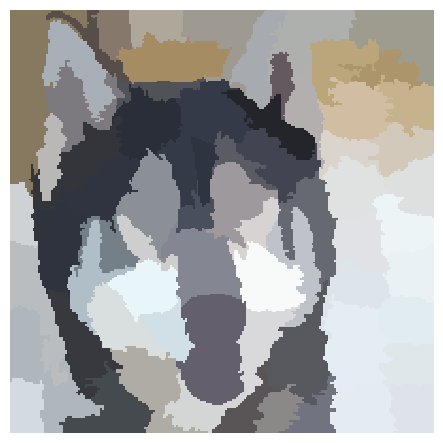

In [27]:
for i, (s, o) in zip(segments_no, segments_step):
    print(f'Segments #: {s.segments_number} (set to {i})')

    all_mask = np.zeros(s.segments_number, dtype=np.int8)
    img_occ = o.occlude_segments_vectorised(all_mask)

    img_pred = clf.proba2tuple(clf.predict_proba([img_occ]), labels_no=1000)[0]
    print('Top 5 predictions: ', img_pred[:5])
    print('Dog predictions: ', find_dog_prediction(img_pred))

    imshow(img_occ)
    plt.imsave(f'_figures/husky_mosaic_{s.segments_number:d}.jpeg', img_occ)

## Mock Surrogate Explanation -- Image

In [28]:
mock_explanation = [
    -0.01, -0.04, 0.01, 0.41, 0.01, -0.01, 0.08, 0.33, -0.02, 0.02, 0.04]

In [29]:
top_n = 5

highlight_mask = []
for i, v in enumerate(mock_explanation):
    c = (255, 0, 0) if v < 0 else (0, 255, 0)
    c_ = 'red' if v < 0 else 'green'
    highlight_mask.append((i + 1, v, c, c_))
highlight_mask = sorted(highlight_mask, key=lambda i: abs(i[1]), reverse=True)

seg, col = [], []
for s, _, c, _ in highlight_mask[:top_n]:
    seg.append(s)
    col.append(c)

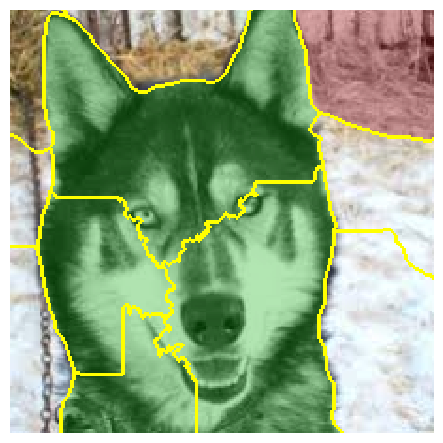

In [30]:
husky_explanation = segmenter.highlight_segments(seg, colour=col)
husky_explanation_ = segmenter.mark_boundaries(
    image=husky_explanation, colour=(255, 255, 0))

imshow(husky_explanation_)

plt.imsave('_figures/husky_explanation.pdf', husky_explanation_)# jpeg

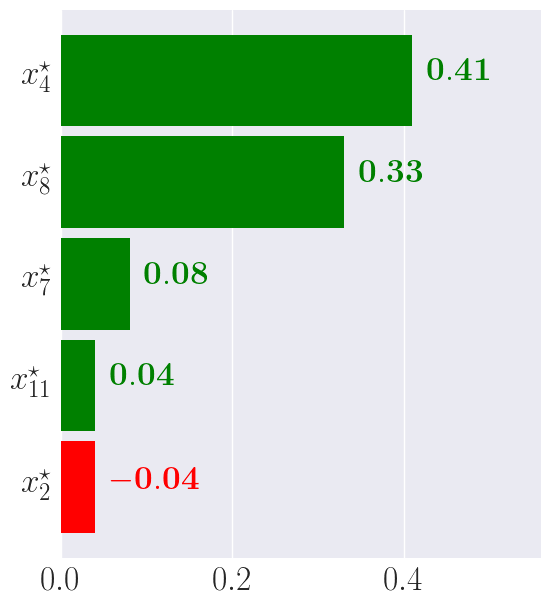

In [31]:
# NBVAL_IGNORE_OUTPUT
# fontsize=14 # labelsize=16
# xlim = (-0.001, 0.017) # xlim = (-0.01, 0.76)
plot_bar_exp(mock_explanation, savepath='_figures/husky_bar.pdf', onesided=True,
             label_fmt='\\(x_{{{:d}}}^\star\\)')

## Mock Surrogate Explanation -- Text

In [32]:
mock_explanation_txt = [
    0, 0.1, 0, 0, 0.7, -0.1, 0, -0.3, 0]
#   0.7, 0, -0.1, 0, 0, 0, -0.3, 0.1, 0

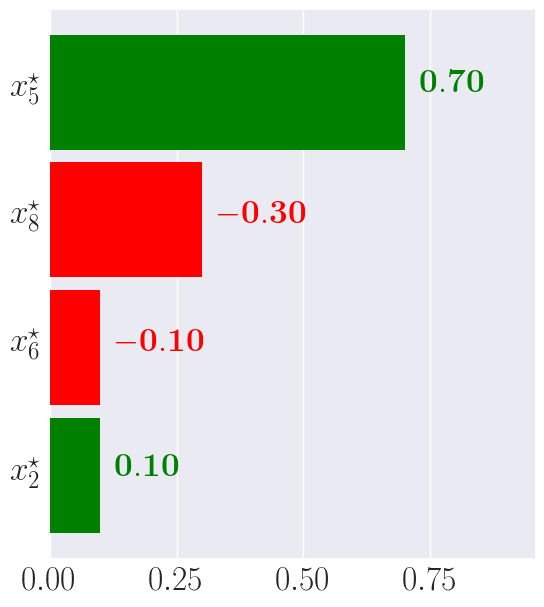

In [33]:
# NBVAL_IGNORE_OUTPUT
# fontsize=14 # labelsize=16
# xlim = (-0.001, 0.017) # xlim = (-0.01, 0.76)
plot_bar_exp(
    mock_explanation_txt,
    savepath='_figures/text_bar.pdf',
    onesided=True,
    feature_no=4,
    label_fmt='\\(x_{{{:d}}}^\star\\)')